In [ ]:

# Load necessary Libraries
import statsmodels.api as sm
import pandas as pd
import numpy as np
import itertools
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
from math import sqrt


from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller     # for ACF, PACF

# loading libraries for arima model
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [55]:
#predefine plotting styles
plt.style.use("fivethirtyeight")
matplotlib.rcParams['axes.labelsize']=14
matplotlib.rcParams['xtick.labelsize']=12
matplotlib.rcParams['ytick.labelsize']=12
matplotlib.rcParams['text.color']='k'
#it groups together all families and predefine all the settigs for plots


In [56]:
# read the data files
df=pd.read_csv("C:/Users/Preeti Singla/Downloads/Great lakes/drive-download-20181223T124334Z-001/8. Time Series/airline.csv")
df.head()

,Month,Passenger
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


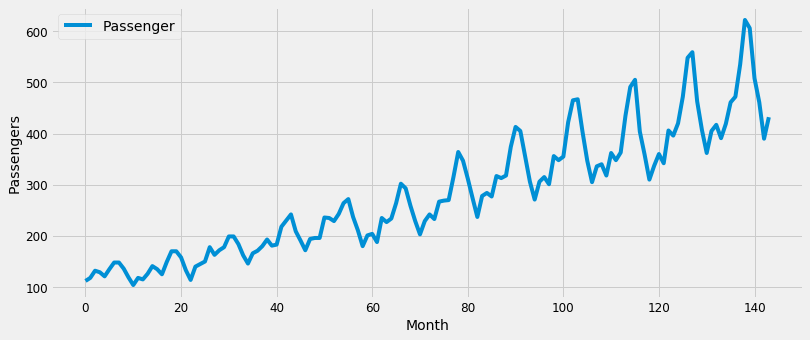

In [57]:
# Plot the time-series
df.plot(figsize=(12,5))
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.show()

#inference: linearly increasing and seasonality in data too

In [58]:
#month column is not readable in the required format, we convert
df['Month']=pd.to_datetime(df['Month'])
df['Month'].head()

#data is now set up for plotting

0   1949-01-01
1   1949-02-01
2   1949-03-01
3   1949-04-01
4   1949-05-01
Name: Month, dtype: datetime64[ns]

In [59]:
df=df.set_index('Month')

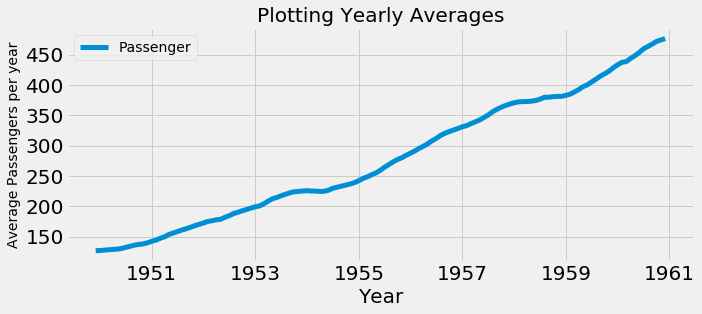

In [60]:
#Identifying trend in data
passenger=df[['Passenger']]
#so that not whole array is taken, but values from each record is taken
passenger.rolling(12).mean().plot(figsize=(10,4),linewidth=5,fontsize=20)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Average Passengers per year')
plt.title('Plotting Yearly Averages')
plt.legend()
#this is the trend estimated in the moving averages
#Since the average is increasing, there is trend

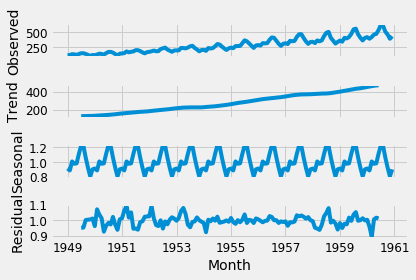

Month
1949-01-01           NaN
1949-02-01           NaN
1949-03-01           NaN
1949-04-01           NaN
1949-05-01           NaN
1949-06-01           NaN
1949-07-01    126.791667
1949-08-01    127.250000
1949-09-01    127.958333
1949-10-01    128.583333
1949-11-01    129.000000
1949-12-01    129.750000
1950-01-01    131.250000
1950-02-01    133.083333
1950-03-01    134.916667
1950-04-01    136.416667
1950-05-01    137.416667
1950-06-01    138.750000
1950-07-01    140.916667
1950-08-01    143.166667
1950-09-01    145.708333
1950-10-01    148.416667
1950-11-01    151.541667
1950-12-01    154.708333
1951-01-01    157.125000
1951-02-01    159.541667
1951-03-01    161.833333
1951-04-01    164.125000
1951-05-01    166.666667
1951-06-01    169.083333
                 ...    
1958-07-01    381.833333
1958-08-01    383.666667
1958-09-01    386.500000
1958-10-01    390.333333
1958-11-01    394.708333
1958-12-01    398.625000
1959-01-01    402.541667
1959-02-01    407.166667
1959-03-01    411.8

In [61]:
#multiplicative because variance is increasing
#=trend*seasonality+Stationary series
s=sm.tsa.seasonal_decompose(passenger.Passenger,model="multiplicative")
fig=s.plot()
plt.show()
s.resid
s.seasonal
s.trend
#Here in 2nd graph first 12 and last 12 are trucated...as rolling

In [84]:
# Creating training and test data
train=passenger[:144]
test=passenger[120:]

In [85]:
result=adfuller(train['Passenger'],autolag='AIC')
print('ADF Static : %f'%result[0])
print('p-value : %f'% result[1])
print('AIC : %f'%result[5])
print('Critical Values : ')
for key,value in result[4].items():
    print('\t%s : %3f'%(key,value))
#high p-value means data is not stationary

ADF Static : 0.815369
p-value : 0.991880
AIC : 996.692931
Critical Values : 
	1% : -3.481682
	5% : -2.884042
	10% : -2.578770


In [86]:
result

(0.8153688792060423,
 0.9918802434376409,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.6929308390189)

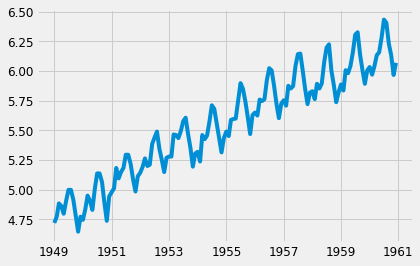

In [87]:
#Taking log to stabalize the increasing variance, VARIANCE STABLIZATION
log_train=np.log(train['Passenger'])
plt.plot(log_train)

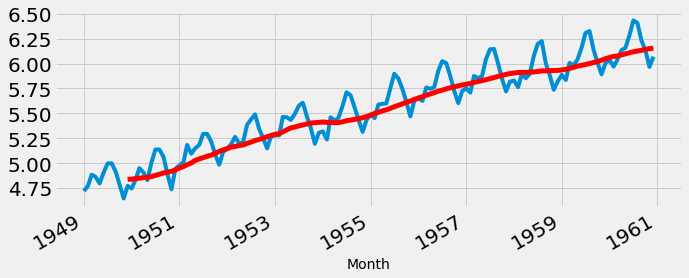

In [88]:
#Moving aveage plot along with the log of data
plt.plot(log_train)
moving_avg=log_train.rolling(12).mean().plot(figsize=(10,4),linewidth=5,fontsize=20,color='red')

Without ADF also, it is visible that data is not statioary

In [89]:
result=adfuller(log_train,autolag='AIC')
print('ADF Static : %f'%result[0])
print('p-value : %f'% result[1])
print('AIC : %f'%result[5])
print('Critical Values : ')
for key,value in result[4].items():
    print('\t%s : %3f'%(key,value))
#high p-value means data is not stationary

ADF Static : -1.717017
p-value : 0.422367
AIC : -445.399031
Critical Values : 
	1% : -3.481682
	5% : -2.884042
	10% : -2.578770


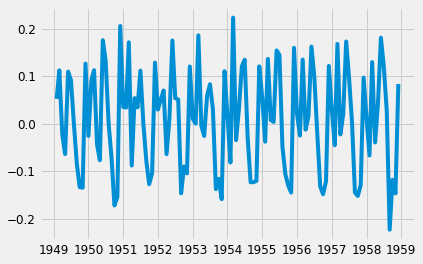

In [90]:
#After differenting, observe plot
log_train_diff=log_train-log_train.shift()
plt.plot(log_train_shift)

In [91]:
#wont work because of nan
log_train_diff.head()
#First value is nan...which produces all incorrect further values, so we drop nan again see

Month
1949-01-01         NaN
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
Name: Passenger, dtype: float64

In [92]:
log_train_diff.dropna(inplace=True)

In [2]:
result=adfuller(log_train_diff,autolag='AIC')
print('ADF Static : %f'%result[0])
print('p-value : %f'% result[1])
print('AIC : %f'%result[5])
print('Critical Values : ')
for key,value in result[4].items():
    print('\t%s : %3f'%(key,value))
#high p-value means data is not stationary

NameError: name 'log_train_diff' is not defined

still p-value is greater than 0.05, so data is not stationary
But here 0.05 is not mandatory, this is set by the client..so we move further

#### Thus d=1

In [94]:
# ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
log_acf=acf(log_train_diff, nlags=20)
log_pacf=pacf(log_train_diff, nlags=20,method='ols')

Text(0.5,1,'Autocorrelation Function')

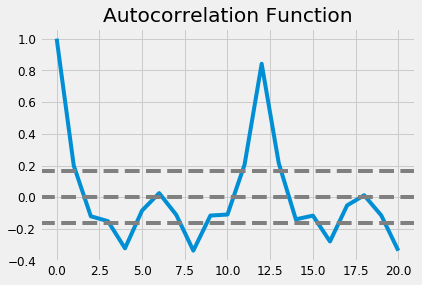

In [95]:
plt.plot(log_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(log_train_diff)),linestyle=('--'),color='gray')
plt.axhline(y=1.96/np.sqrt(len(log_train_diff)),linestyle=('--'),color='gray')
plt.title('Autocorrelation Function')

going after 5 lags, no meaning, the patterns decreases

no meaning of checking data before 7 years...no pattern...7 lags meaning 7 repeating seasonality

#### q=1,4

Text(0.5,1,'Partial Autocorrelation Function')

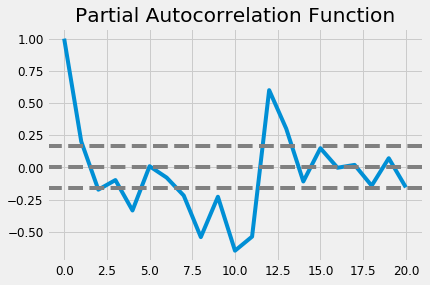

In [96]:
plt.plot(log_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(log_train_diff)),linestyle=('--'),color='gray')
plt.axhline(y=1.96/np.sqrt(len(log_train_diff)),linestyle=('--'),color='gray')
plt.title('Partial Autocorrelation Function')

#### p=1,2,4

In [97]:
#till now we have found
# d=1
# q=1,4
# p=1,2,4

-237.60463569752807


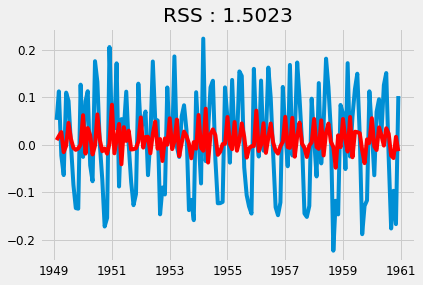

In [135]:
# AR model
model1=ARIMA(log_train,order=(2,1,0))
results_AR1=model1.fit(disp=-1)
plt.plot(log_train_diff)
plt.plot(results_AR1.fittedvalues,color='red')
plt.title('RSS : %.4f'%sum((results_AR1.fittedvalues-log_train_diff)**2))
print(results_AR1.aic)
#here data used is log_train but we are plotting log_train_diff
#becuse purpose of using log_train_diff is to find the value of d,q,p
#then we apply our modelon original data which was log_train

In [103]:
#we see that our stationary data and predicted values has high difference.
#we then move to next model

-237.507314985542


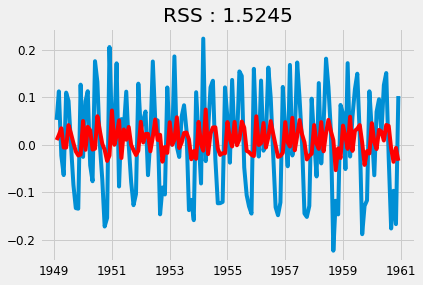

In [136]:
# MA model
model2=ARIMA(log_train,order=(0,1,1))
results_AR2=model2.fit(disp=-1)
plt.plot(log_train_diff)
plt.plot(results_AR2.fittedvalues,color='red')
plt.title('RSS : %.4f'%sum((results_AR2.fittedvalues-log_train_diff)**2))
print(results_AR2.aic)
#here data used is log_train but we are plotting log_train_diff
#becuse purpose of using log_train_diff is to find the value of d,q,p
#then we apply our modelon original data which was log_train

In [106]:
#still not a good model

-241.60771402611368


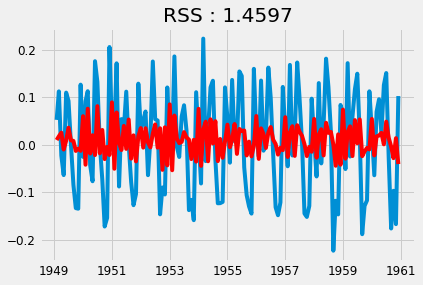

In [137]:
# ARIMA model with (p,d,q)=(1,1,1)
model3=ARIMA(log_train,order=(1,1,1))
results_AR3=model3.fit(disp=-1)
plt.plot(log_train_diff)
plt.plot(results_AR3.fittedvalues,color='red')
plt.title('RSS : %.4f'%sum((results_AR3.fittedvalues-log_train_diff)**2))
print(results_AR3.aic)
#here data used is log_train but we are plotting log_train_diff
#becuse purpose of using log_train_diff is to find the value of d,q,p
#then we apply our modelon original data which was log_train

-275.47166928006715


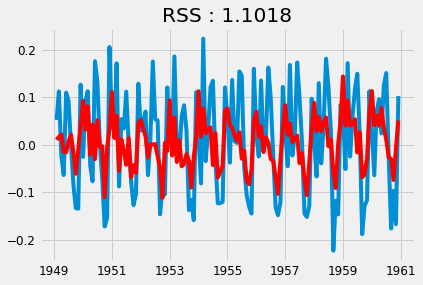

In [138]:
# ARIMA model with (p,d,q)=(1,1,4)
model4=ARIMA(log_train,order=(1,1,4))
results_AR4=model4.fit(disp=-1)
plt.plot(log_train_diff)
plt.plot(results_AR4.fittedvalues,color='red')
plt.title('RSS : %.4f'%sum((results_AR4.fittedvalues-log_train_diff)**2))
print(results_AR4.aic)
#here data used is log_train but we are plotting log_train_diff
#becuse purpose of using log_train_diff is to find the value of d,q,p
#then we apply our modelon original data which was log_train

-270.15121633193786


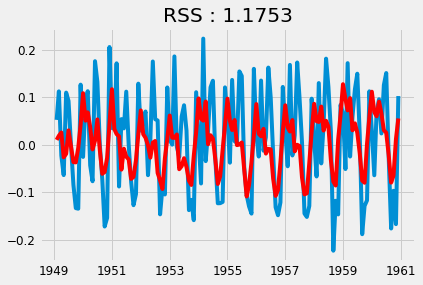

In [139]:
# ARIMA model with (p,d,q)=(2,1,1)
model5=ARIMA(log_train,order=(2,1,1))
results_AR5=model5.fit(disp=-1)
plt.plot(log_train_diff)
plt.plot(results_AR5.fittedvalues,color='red')
plt.title('RSS : %.4f'%sum((results_AR5.fittedvalues-log_train_diff)**2))
print(results_AR5.aic)
#here data used is log_train but we are plotting log_train_diff
#becuse purpose of using log_train_diff is to find the value of d,q,p
#then we apply our modelon original data which was log_train

-293.4278124982523


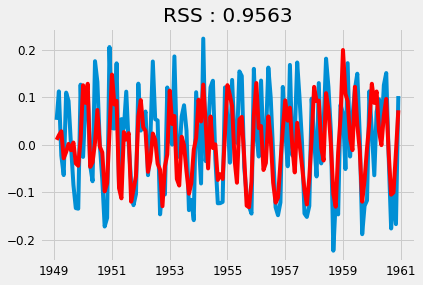

In [140]:
# ARIMA model with (p,d,q)=(2,1,4)
model6=ARIMA(log_train,order=(2,1,4))
results_AR6=model6.fit(disp=-1)
plt.plot(log_train_diff)
plt.plot(results_AR6.fittedvalues,color='red')
plt.title('RSS : %.4f'%sum((results_AR6.fittedvalues-log_train_diff)**2))
print(results_AR6.aic)
#here data used is log_train but we are plotting log_train_diff
#becuse purpose of using log_train_diff is to find the value of d,q,p
#then we apply our modelon original data which was log_train

-274.4106560770596


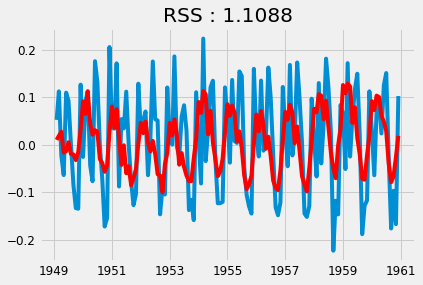

In [141]:
# ARIMA model with (p,d,q)=(4,1,1)
model7=ARIMA(log_train,order=(4,1,1))
results_AR7=model7.fit(disp=-1)
plt.plot(log_train_diff)
plt.plot(results_AR7.fittedvalues,color='red')
plt.title('RSS : %.4f'%sum((results_AR7.fittedvalues-log_train_diff)**2))
print(results_AR7.aic)
#here data used is log_train but we are plotting log_train_diff
#becuse purpose of using log_train_diff is to find the value of d,q,p
#then we apply our modelon original data which was log_train

-302.4590787778779


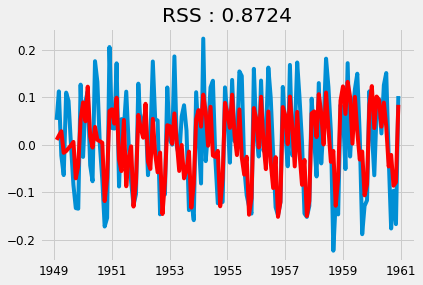

In [142]:
# ARIMA model with (p,d,q)=(4,1,4)
model8=ARIMA(log_train,order=(4,1,4))
results_AR8=model8.fit(disp=-1)
plt.plot(log_train_diff)
plt.plot(results_AR8.fittedvalues,color='red')
plt.title('RSS : %.4f'%sum((results_AR8.fittedvalues-log_train_diff)**2))
print(results_AR8.aic)
#here data used is log_train but we are plotting log_train_diff
#becuse purpose of using log_train_diff is to find the value of d,q,p
#then we apply our modelon original data which was log_train

This is the best model.

Since highest aic value and lowest RSS

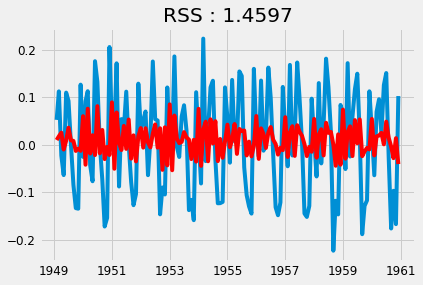

-241.60771402611368


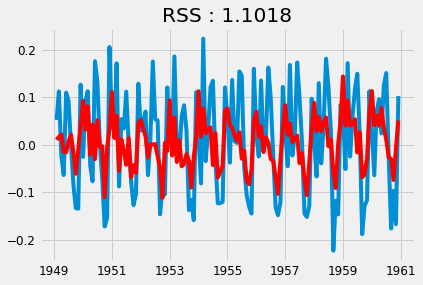

-275.47166928006715


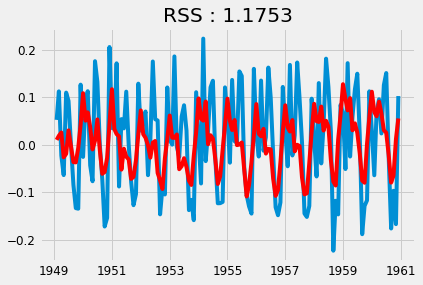

-270.15121633193786


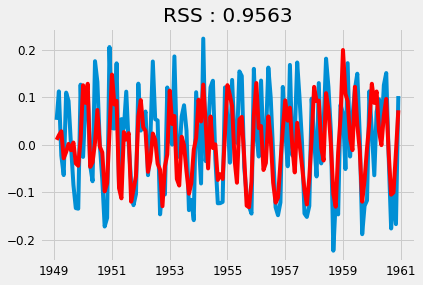

-293.4278124982523


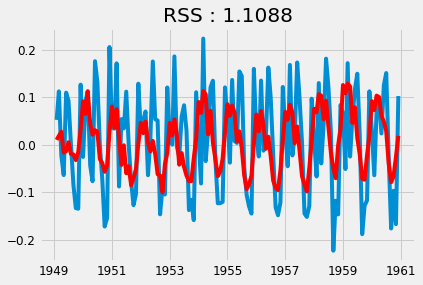

-274.4106560770596


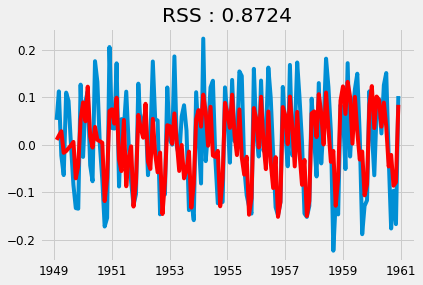

-302.4590787778779


In [116]:
# ARIMA model with (p,d,q)=(4,1,4)
for p in [1,2,4]:
    for q in[1,4]:
        for d in [1]:
            modell=ARIMA(log_train,order=(p,d,q))
            results_AR=modell.fit(disp=-1)
            plt.plot(log_train_diff)
            plt.plot(results_AR.fittedvalues,color='red')
            plt.title('RSS : %.4f'%sum((results_AR.fittedvalues-log_train_diff)**2))
            plt.show()
            print(results_AR.aic)
            #here data used is log_train but we are plotting log_train_diff
            #becuse purpose of using log_train_diff is to find the value of d,q,p
            #then we apply our modelon original data which was log_train

In [143]:
#Going back to original scale
#Step 1: Notice that the values start from 2nd month of 1949
#where first month of 1949 is january
predictions_ARIMA_diff=pd.Series(results_AR8.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-02-01    0.010102
1949-03-01    0.019083
1949-04-01    0.028269
1949-05-01   -0.017163
1949-06-01   -0.013447
dtype: float64

In [144]:
#Step 2:
predictions_ARIMA_diff_cumsum=predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.010102
1949-03-01    0.029185
1949-04-01    0.057454
1949-05-01    0.040292
1949-06-01    0.026845
dtype: float64

In [145]:
#Step 3:
#log_train
#log_train.ix[0]
predictions_ARIMA_log=pd.Series(log_train.ix[0], index=log_train.index)
predictions_ARIMA_log=predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728601
1949-03-01    4.747684
1949-04-01    4.775953
1949-05-01    4.758791
dtype: float64

In [146]:

predictions_ARIMA_log1=log_train.add(predictions_ARIMA_diff,fill_value=0)
predictions_ARIMA_log1.head()

Month
1949-01-01    4.718499
1949-02-01    4.780787
1949-03-01    4.901885
1949-04-01    4.888082
1949-05-01    4.778628
dtype: float64

Text(0.5,1,'RMSE : 198.1759')

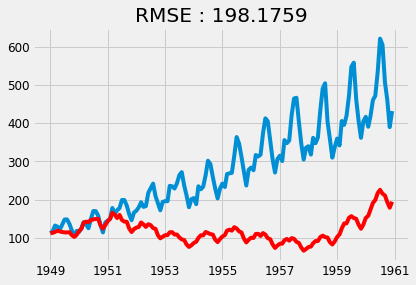

In [147]:
#Predictions
predictions_ARIMA=np.exp(predictions_ARIMA_log)
plt.plot(train['Passenger'])
plt.plot(predictions_ARIMA, color='red')
plt.title('RMSE : %.4f'%np.sqrt(np.mean((predictions_ARIMA-train['Passenger'])**2)))

In [148]:
# Problem with arima, earlier least rms
#but in real it adds high errors
#best works with (1,1,1)

In [133]:
results_AR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Passenger   No. Observations:                  143
Model:                 ARIMA(4, 1, 4)   Log Likelihood                 161.230
Method:                       css-mle   S.D. of innovations              0.075
Date:                Fri, 04 Jan 2019   AIC                           -302.459
Time:                        16:00:50   BIC                           -272.831
Sample:                    02-01-1949   HQIC                          -290.419
                         - 12-01-1960                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0101      0.000     28.695      0.000       0.009       0.011
ar.L1.D.Passenger     0.2643      0.117      2.257      0.026       0.035       0.494
ar.L2.D.Passenger    -0.3959      0.052     -7.547      0.000      -0.499      -0.293
ar.L3.D.Passenger     0.6135      0.057     10.768      0.000       0.502       0.725
ar.L4.D.Passenger    -0.6190      0.096     -6.459      0.000      -0.807      -0.431
ma.L1.D.Passenger    -0.1905      0.162     -1.176      0.242      -0.508       0.127
ma.L2.D.Passenger     0.1133      0.062      1.835      0.069      -0.008       0.234
ma.L3.D.Passenger    -1.0090      0.064    -15.729      0.000      -1.135      -0.883
ma.L4.D.Passenger     0.0861      0.159      0.540      0.590      -0.226       0.399
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.4962           -0.8757j            1.0065           -0.3320
AR.2           -0.4962           +0.8757j            1.0065            0.3320
AR.3            0.9917           -0.7818j            1.2628           -0.1063
AR.4            0.9917           +0.7818j            1.2628            0.1063
MA.1           -0.4478           -0.8941j            1.0000           -0.3239
MA.2           -0.4478           +0.8941j            1.0000            0.3239
MA.3            1.0000           -0.0000j            1.0000           -0.0000
MA.4           11.6080           -0.0000j           11.6080           -0.0000
-----------------------------------------------------------------------------
"""

Text(0.5,1,'RMSE : 52.4891')

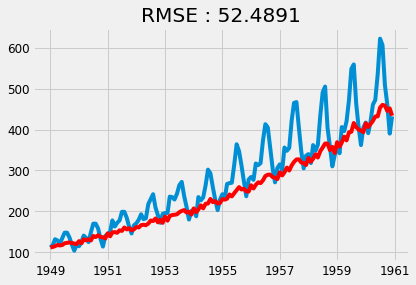

In [149]:
#Going back to original scale
#Step 1: Notice that the values start from 2nd month of 1949
#where first month of 1949 is january
predictions_ARIMA_diff=pd.Series(results_AR3.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

#Step 2:
predictions_ARIMA_diff_cumsum=predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

#Step 3:
#log_train
#log_train.ix[0]
predictions_ARIMA_log=pd.Series(log_train.ix[0], index=log_train.index)
predictions_ARIMA_log=predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

predictions_ARIMA_log1=log_train.add(predictions_ARIMA_diff,fill_value=0)
predictions_ARIMA_log1.head()

#Predictions
predictions_ARIMA=np.exp(predictions_ARIMA_log)
plt.plot(train['Passenger'])
plt.plot(predictions_ARIMA, color='red')
plt.title('RMSE : %.4f'%np.sqrt(np.mean((predictions_ARIMA-train['Passenger'])**2)))

In [150]:
#This is very good model

In [151]:
results_AR3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Passenger   No. Observations:                  143
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 124.804
Method:                       css-mle   S.D. of innovations              0.101
Date:                Fri, 04 Jan 2019   AIC                           -241.608
Time:                        16:07:03   BIC                           -229.756
Sample:                    02-01-1949   HQIC                          -236.792
                         - 12-01-1960                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0098      0.010      0.993      0.322      -0.010       0.029
ar.L1.D.Passenger    -0.5826      0.128     -4.536      0.000      -0.834      -0.331
ma.L1.D.Passenger     0.8502      0.086      9.936      0.000       0.682       1.018
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.7165           +0.0000j            1.7165            0.5000
MA.1           -1.1762           +0.0000j            1.1762            0.5000
-----------------------------------------------------------------------------
"""